In [1]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm


# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [2]:
dataset_dir = "/data_dir"
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


In [3]:
TRAIN_END = "2017-12-31"
VAL_START = "2018-02-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"

# 2.8.1. 特徴量の生成

1. 財務データの取得及び前処理（Chapter2.5.2と同様）
2. マーケットデータの取得及び特徴量定義（Chapter2.6.3と同様）
3. 財務データと生成した特徴量を結合

In [4]:
def get_features_for_predict(dfs, code):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"].copy()

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    fin_data["datetime"] = pd.to_datetime(fin_data["base_date"])
    fin_data.set_index("datetime", inplace=True)
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"].copy()
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    price_data["datetime"] = pd.to_datetime(price_data["EndOfDayQuote Date"])
    price_data.set_index("datetime", inplace=True)
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    return feats

In [5]:
# df = get_features_for_predict(dfs, 9984)
# df.T

# 2.8.2. 目的変数の対応付け及び訓練データ、評価データ、テストデータの分割


In [6]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"].copy()
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]
        # 日付列をpd.Timestamp型に変換してindexに設定
        stock_labels["datetime"] = pd.to_datetime(stock_labels["base_date"])
        stock_labels.set_index("datetime", inplace=True)

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END].copy()
            _val_X = feats[VAL_START : VAL_END].copy()
            _test_X = feats[TEST_START :].copy()

            _train_y = labels[: TRAIN_END].copy()
            _val_y = labels[VAL_START : VAL_END].copy()
            _test_y = labels[TEST_START :].copy()

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [7]:
# # 対象銘柄コードを定義
# codes = [9984]
# # 対象の目的変数を定義
# label = "label_high_20"
# # 特徴量を取得
# feat = get_features_for_predict(dfs, codes[0])
# # 特徴量と目的変数を入力し、分割データを取得
# ret = get_features_and_label(dfs, codes, feat, label)
# for v in ret:
#     print(v.T)

In [8]:
def get_codes(dfs):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    stock_list = dfs["stock_list"].copy()
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [21]:
# 対象の目的変数を定義
labels = {
    # "label_high_5",   # 基準日付の終値から5営業日の間の最高値への変化率
    # "label_high_10",  # 基準日付の終値から10営業日の間の最高値への変化率
    "label_high_20",
    # "label_low_5",    # 基準日付の終値から5営業日の間の最安値への変化率
    # "label_low_10",
    # "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

codes = codes[0:300]

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

# 2.8.3. モデル学習の実行方法

In [22]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

# 2.9. モデルの推論
## 2.9.1. 予測結果の出力方法


In [23]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 学習用データセット定義
# ファンダメンタル情報
fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 学習用データセットを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"]
)

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


# 2.9.2. 予測結果の可視化方法


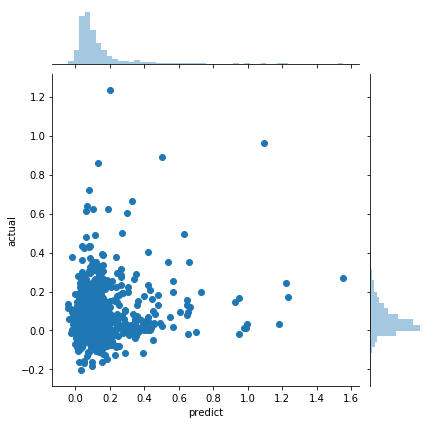

In [24]:
sns.jointplot(data=result[label], x="predict", y="actual")

# 2.10. 予測結果に対する分析の道筋
## 2.10.1. 特徴量の重要度
特徴量の重要度は、Random ForestやGradient Boostingなどのいくつかの機械学習モデルで取得でき、モデル内でどの程度それぞれの説明変数が、目的変数に対して重要であるかを判断するために参考になる指標です。

重要度が極端に低いものは、そもそも説明変数から除外したり、重要度が高いものは更に分析することで、性能の向上が期待できないか、など分析の道筋をつける上でも役に立ちます。

Text(0.5, 0, 'Random Forest Feature Importance')

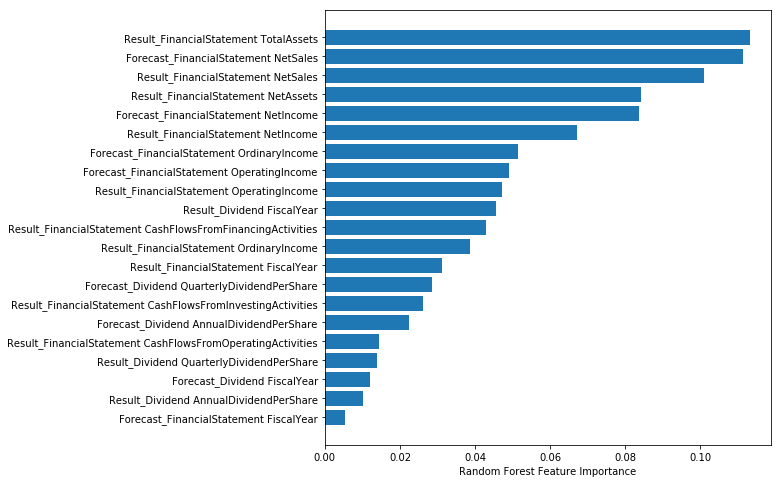

In [25]:
# 学習済みモデルを指定
rf = pred_model

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

一番上にある NetAssets(純資産) にモデルが注目していることがわかります。純資産は資本金や利益剰余金などを合算した指標で、次に登場する TotalAssets(総資産) から負債を引いたものとなります。

# 2.10.2. SHAP


model_output = "margin" has been renamed to model_output = "raw"


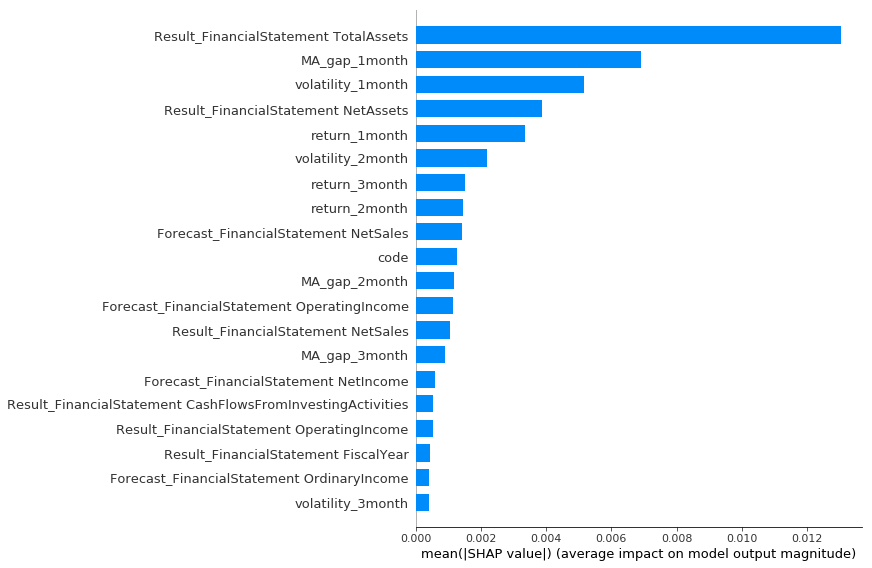

In [26]:
# モデルを定義します
sample_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X["label_high_20"], label=train_y["label_high_20"]), 100)

# 次にshap値を求めます。
shap.initjs()
explainer = shap.TreeExplainer(model=sample_model, feature_perturbation='tree_path_dependent', model_output='margin')
# SHAP値
shap_values = explainer.shap_values(X=train_X["label_high_20"])
# プロット
shap.summary_plot(shap_values, train_X["label_high_20"], plot_type="bar")


### 次にshapのsummary_plotを確認します。これは特徴量を少し変化させた時の学習のインパクトを表しています。


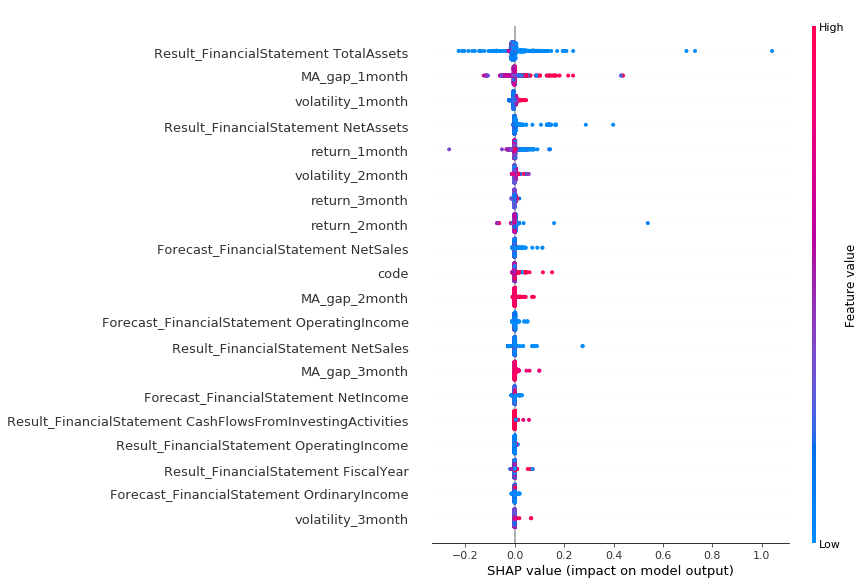

In [28]:
shap.summary_plot(shap_values, train_X["label_high_20"])


Total Assets が1番目にモデルに影響を与える特徴量であることがわかります。**プラス方向、マイナス方向に関わらず青い色が多いので、モデルが Total Assets が小さい場合にこの特徴量を活用していることがわかります。 Net Assets も同様の傾向が観測されます**

volatility_1month がモデルに大きな影響を与える特徴量であることがわかります。この特徴量は赤い時にプラス方向(高値が大きくなる)の影響が大きいことがわかります。これはボラティリティが上昇すると高値が高くなるということを意味するので直感に合致します。

MA_gap_1_month が小さい時にプラス方向(高値が大きくなる)に影響を与えています。移動平均乖離率が小さいときは移動平均線がその時点の株価よりも下にいる期間なので、その時に高値が伸びるのは株価が反転している可能性が高いのかもしれません。